In [8]:
import numpy as np

如下为使用了损失函数的神经网络的类结构

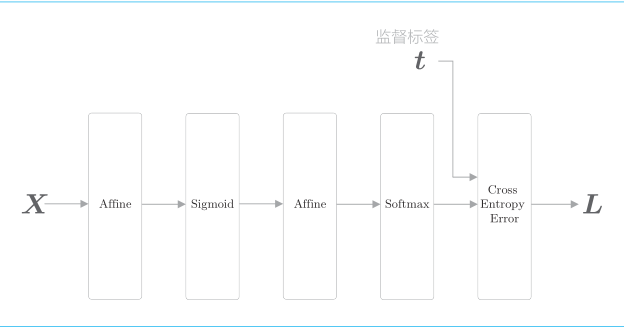

## 交叉熵误差

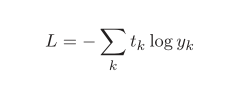

$t_k$是对应于第k个类别的监督标签。log是以e为底的对数。监督标签以one-hot向量的形式表示，比如t = (0,0,1)

$L$实际上计算正确标签为1的元素所对应的输出的自然对数

函数内部在计算np.log时，加上了一个微小值delta。这是因为，当出现np.log(0)时，np.log(0)会变为负无限大的-inf，这样一来就会导致后续计算无法进行。作为保护性对策，添加一个微小值可以防止负无限大的发生。

### 单个数据的交叉熵误差

In [7]:
def cross_entroy_error_single(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta)) # * 代表向量按元素相乘

### mini-batch版本的交叉熵误差
定义可以同时处理单个数据和批量数据的两种情况的函数

In [ ]:
def cross_entroy_error(y, t):
    if y.ndim == 1: # 即单个数据
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 若监督标签是one-hot-vector形式，可以转换成正确解标签的索引，这样可以简便计算过程
    if t.size == y.size:
        t = t.argmax(axis=1)
    # t 为一个批次中每一个样本的正确解标签的索引形成的向量
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

## Sigmoid
在前一节的基础上完善sigmoid函数，增加反向传播过程

### sigmoid的计算图

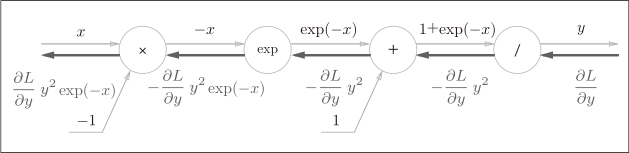

### sigmoid的简洁计算图
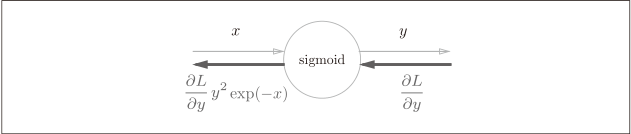

整理后可得

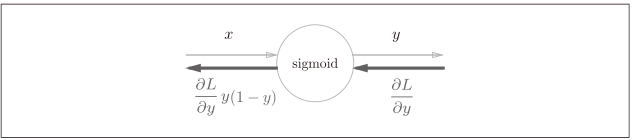

### sigmoid（不带loss）

In [4]:
class Sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None
    
    def forward(self, x):
        out = 1 / (1 + np.exp((-x)))
        self.out = out
        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

### sigmoid（含loss）

In [1]:
class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None # sigmoid的输出
        self.t = None # 监督标签
    
    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))
        
        self.loss =  cross_entroy_error(np.c_[1 - self.y, self.y], self.t)
        
        return self.loss
    
    def backward(self, dout=1):
        """ ???  """
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) * dout / batch_size
        return dx

## MatMul节点

MatMul节点是矩阵乘积节点。

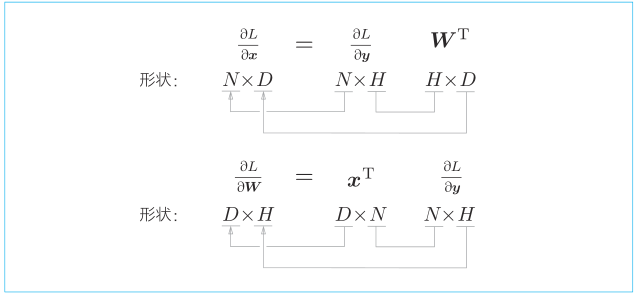

In [4]:
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None
        
    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out
    
    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx

上述实现代码中使用了省略号的方式对self.grads进行了修改。
使用省略号可以进行深复制，可以固定变量的内存地址。
在grads列表中保存各个参数的梯度。此时，grads列表中的各个元素是 NumPy 数组，仅在生成层时生成一次。然后，使用省略号，在不改变 NumPy 数组的内存地址的情况下覆盖数据。这样一来，
将梯度汇总在一起的工作就只需要在开始时进行一次即可。

## Affine层

几何中，仿射变换包括一次线性变换和一次平移，分别对应神经网络的加权和运算与加偏置运算。
矩阵的乘积运算在几何中称为 仿射变换， 故称为 Affine层

### Affine层的计算图（单样本）

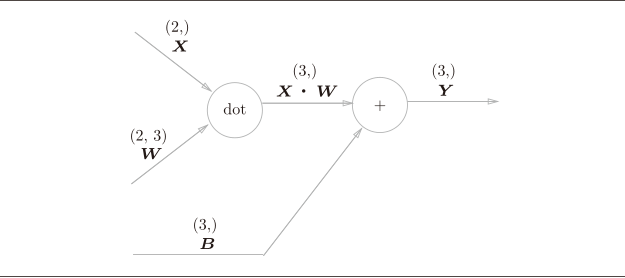

### Affine层的反向传播（单样本）

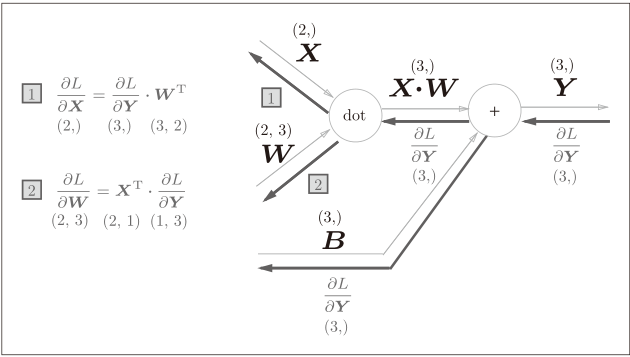

### 批版本的Affine层的计算图

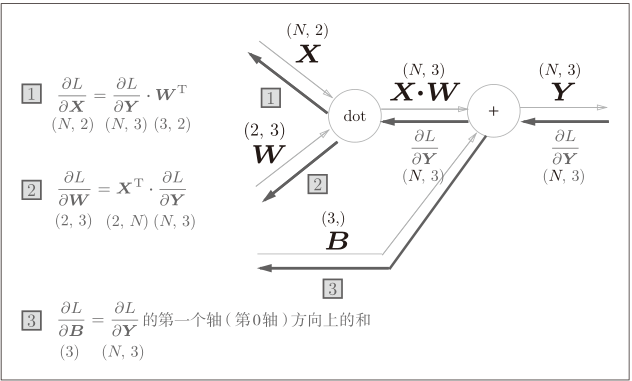

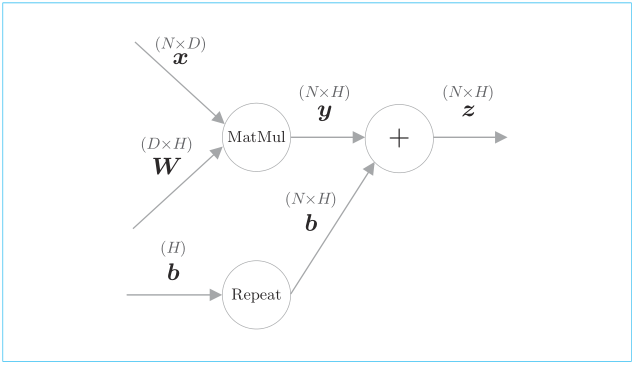

### 实现

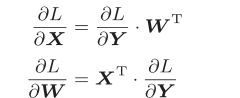

正向传播时，偏置会被加到每一个数据（第1个、第2个……）上。因此，反向传播时，各个数据的反向传播的值需要汇总为偏置的元素

In [ ]:
class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None
        
    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W)
        self.x = x
        reutrn out
        
    def backward(self):
        W, b = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        db = np.sum(dout, axis=0)
        
        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx

## Softmax函数

softmax函数可由下式表示

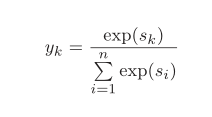

以上是当输出总共有n个时，计算第k个输出$y_k$的算式，对应于第k个类别的Softmax函数的输出。Softmax函数输出的元素之和是1，因此输出可以解释为概率。之后，将概率输入到交叉熵误差。
同时，为了防止sotmax中的exp值过大导致结果为nan，可进行改进，下式中C'一般取输入信号中的最大值。

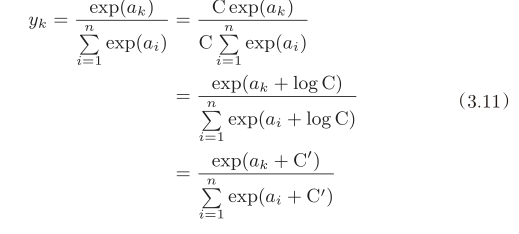

In [12]:
def softmax_single(x):
    x = x - np.max(x)
    x = np.exp(x) / np.sum(np.exp(x))

一般而言，神经网络只把输出值最大的神经元所对应的类别作为识别结果。并且，即便使用softmax函数，输出值最大的神经元的位置也不会变。因此，神经网络在进行分类时，输出层的softmax函数可以省略。在实际的问题中，由于指数函数的运算需要一定的计算机运算量，因此输出层的softmax函数一般会被省略。

求解机器学习问题的步骤可以分为“学习”A 和“推理”两个阶段。首先，在学习阶段进行模型的学习B，然后，在推理阶段，用学到的模型对未知的数据进行推理（分类）。**如前所述，推理阶段一般会省略输出层的softmax函数,神经网络的推理只需要给出一个答案的情况下，因为此时只对得分最大值感兴趣，所以不需要Softmax层。**。在输出层使用softmax函数是因为它和神经网络的学习有关系

In [10]:
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x

### Softmax
backward不是很明白

In [13]:
class Softmax:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None
        
    def forward(self, x):
        self.out = softmax(x)
        return self.out
    
    def backward(self, dout):
        dx = self.out * dout
        sumdx = np.sum(dx, axis=1, keepdims=True)
        dx -= self.out * sumdx
        return dx

### SoftmaxWithLoss
也就是将softmax层和cross entroy error层合并

### 简易版的Softmax With Loss层的计算图

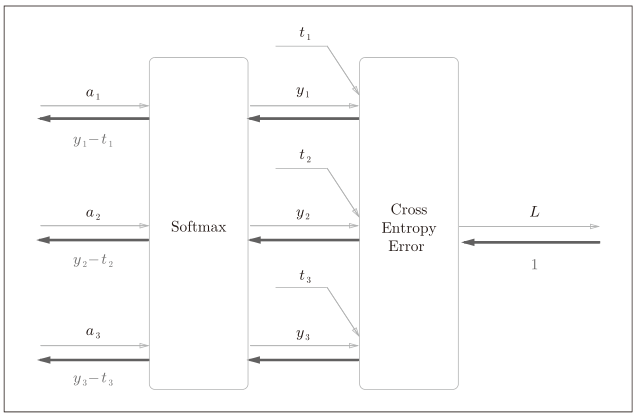

Softmax层的反向传播得到了（y1− t1, y2− t2, y3− t3）这样“漂亮”的结果。由于（y1, y2, y3）是Softmax层的输出，（t1, t2, t3）是监督数据，所以（y1− t1, y2− t2, y3− t3）是Softmax层的输出和教师标签的差分。神经网络的反向传播会把这个差分表示的误差传递给前面的层，这是神经网络学习中的重要性质。
使用交叉熵误差作为 softmax 函数的损失函数后，反向传播得到（y1− t1, y2− t2, y3− t3）这样 “漂亮”的结果。实际上，这样“漂亮”的结果并不是偶然的，而是为了得到这样的结果，特意设计了交叉
熵误差函数。回归问题中输出层使用“恒等函数”，损失函数使用“平方和误差”，也是出于同样的理由。也就是说，使用“平方和误差”作为“恒等函数”的损失函数，反向传播才能得到（y1−t1, y2− t2, y3− t3）这样“漂亮”的结果。

In [6]:
class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None
        self.t = None
    
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        # 在监督标签为one-hot向量的情况下，转换为正确解标签的索引
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)
            
        loss = cross_entroy_error(self.y, self.t)
        return loss
    
    def backward(self, dout=1):
        # dout默认为1 ，因为 softmax一般为最后一层？
        batch_size = self.t.shape[0]
        
        dx = self.y.copy()
        dx[np.arrange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size
        
        return dx

注意反向传播时，将要传播的值除以批的大小（batch_size）后，传递给前面的层的是单个数据的误差。